# CA2 - ML on Agriculture in Ireland and EU

## Overview

In this notebook, ML techniques were applied on the following datasets related to the agriculture topic:

- Tweets dataset
- Agriculture Import/Export Trade

In the first part of the notebook, it was performed a sentiment analysis on the tweets collected about agriculture and food prices.

The tweets were pre-processed to extract their sentiment for two classification methods, Naive Bayes and Logistic Regression.

In the second part of this notebook, the Import/Export Trade dataset was used to predict the import value and quantity of livestock and crops in Ireland and other countries.

The following models were tested in that analysis: Linear Regression and KNN Regression.

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

The following requirement should be satisfied before running the code in this notebook:

- NLTK library should be installed: The code to install this lib is commented out in the code below.

In [36]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants and modules created for this project
from constants import *
from text_processor import *
from json_helper import *

# uncomment to install any missing lib
# !pip install wordcloud
# !pip install textblob
# !pip install punkt
# import nltk
# nltk.download()

# importing modules specific to this notebook
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob 
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler

# use a logger to help debugging
logger = logging.getLogger('ml')

# set logger level
logger.setLevel(logging.ERROR)

def get_freq(df, colname):
    '''
    Auxiliary function to calculate the frequency distribution of the words in a column.

    Parameters:
        df (DataFrame): Data frame to be processed.
        colname  (str): Column name to get its frequency calculated.
    Returns:
        fdist    (mtx): Frequency distribution of the tokens.
    '''
    tokens_lst = []
    for i in range(0, len(df)):
        text = df.loc[i][colname]
        tokens_lst+= TextProcessor.get_tokens(text)

    fdist = FreqDist(tokens_lst)

    return fdist

def wordcloud_draw(data, color='black'):
    '''
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    '''
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def is_valid_vectorizer(obj):
    '''
    Auxiliary function to validate the vectorizer object.

    Parameters:
        obj (obj): Instance of a vectorizer to be validated.
    Returns:
        True if valid, False otherwise.
    '''
    if isinstance(obj, TfidfVectorizer):
        return True
    if isinstance(obj, CountVectorizer):
        return True
    return False
    
def run_text_vectorizer(df, x_name, vec_inst, max_f=5000):
    '''
    Auxiliary function to run the text vectorizer passed in the input.

    Parameters:
        df (DataFrame): Data frame to be processed.
        x_name   (str): Name of the column to be processed.
        vec_inst (obj): Text vectorizer instance to be used.
    Returns:
        x_vec    (arr): Feature vector extracted from each text in the processed column.
    '''
    if not is_valid_vectorizer(vec_inst):
        raise Exception(f'Not a valid vectorizer! { type(vec_inst) }')

    # getting feat vectors for x_name
    x_vec = vec_inst.fit_transform(df[x_name]).toarray()

    logger.info(f'Feature vector using { type(vec_inst) }: { x_vec.shape }')

    return x_vec

def resample(X, y):
    '''
    Auxiliary function that uses SMOTE technique to resample the input data.
    
    Parameters:
        X (Data Series): Independent variable to be resampled based on the target balance.
        y (Data Series): Target variable to be balanced.
    Returns:
        X_res, y_res: Balanced dataset.
    '''
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res
    
def run_naive_bayes_classifier_cross_val(X, y, cv=5):
    '''
    Auxiliary function to run Naive Bayes classifier using cross validation.

    Parameters:
        X (Series): X variable data.
        y (Series): y Target variable data.
        cv   (int): Number of folds to be used by cross validation function.
    Returns:
        cv_res (dict): Results of the cross validation score method.
    '''  
    model = MultinomialNB()    
    cv_res = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return cv_res
    
def run_naive_bayes_classifier(X, y):
    '''
    Auxiliary function to run Naive Bayes classifier.

    Parameters:
        X (Series): X variable data.
        y (Series): y Target variable data.
    Returns:
        cf (dict): Results of the classifier.
    '''
    # instantiate a naive bayes model classifer
    model = MultinomialNB()
    
    # split the dataset into training and testing parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # train the model by calling a method fit()
    model.fit(X_train, y_train)
    
    # predict test data using the model
    y_pred = model.predict(X_test)
    
    # getting classification report from the model
    cf = classification_report(y_test, y_pred, target_names=sentiment_lst)

    return cf

def run_min_max_scaler(df, colslist=[]):
    '''
    This function applies the min/max scaler to the specified columns.

    Parameters:
        df (DataFrame): Dataset.
        colslist (lst): List of columns to apply the scaler.
    Returns:
        df_scaler: scaled dataset
    '''
    # recaling the variables (both)
    df = df[colslist]
    scaler = MinMaxScaler()
    df_scaler = scaler.fit_transform(df)

    # rename columns (since now its an np array)
    df_scaler = pd.DataFrame(df_scaler)
    df_scaler.columns = colslist
    return df_scaler

def train_test_split_batch(X, y, n_exec=1, ts=.3, rs=42):
    # splitting data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)

    # reshape X train and test data
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)

    # creating y train and test result structure for each execution result
    y_train_pred = np.zeros((len(X_train), n_exec))
    y_test_pred = np.zeros((len(X_test), n_exec))

    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred

def get_r2_score_batch(target_name, y_train, y_train_pred, y_test, y_test_pred, param_list, cv_score_res=[0.0, 0.0]):
    # generating r2 score results per tested param
    r2_batch_res = []

    # calculating the r2 score for each execution of the model with the selected parameter
    for i, param in enumerate(param_list):
        # getting r2 score for the train set
        train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
        # getting r2 score for the test set
        test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
        # appending the results to the data structure        
        r2_batch_res.append([target_name, param, train_r2, test_r2, cv_score_res[i][0], cv_score_res[i][1]])

    return r2_batch_res
    
def run_linear_regression_batch(X, y, target_name, degrees=[1, 5, 10, 15, 20, 25, 30]):
    # getting train and test data for multiple executions of the model with diff degrees
    X_train, X_test, y_train, y_test, y_train_pred, y_test_pred = train_test_split_batch(X, y, len(degrees))

    # trying linear regression with different degrees
    cv_score_res = []
    for i in range(0, len(degrees)):
        # running linear regression to get the prediction values
        y_train_pred_i, y_test_pred_i, cv_score_train, cv_score_test = run_linear_regression(X_train, y_train, X_test, y_test, degrees[i])
        y_train_pred[:, i] = y_train_pred_i
        y_test_pred[:, i]  = y_test_pred_i
        cv_score_res.append([cv_score_train, cv_score_test])
    
    # generate the validation results per degree with r2 score
    lr_results = get_r2_score_batch(target_name, y_train, y_train_pred, y_test, y_test_pred, degrees, cv_score_res)
    
    # return tuple with the results and predicted values for train and test datasets
    return lr_results, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred

def run_knn_regression_batch(X, y, target_name, k=[1, 2, 3, 4, 5]):
    # getting train and test data for multiple executions of the model with diff degrees
    X_train, X_test, y_train, y_test, y_train_pred, y_test_pred = train_test_split_batch(X, y, len(k))

    # trying knn regression with different k value
    cv_score_res = []
    for i in range(0, len(k)):
        y_train_pred_i, y_test_pred_i, cv_score_train, cv_score_test = run_knn_regression(X_train, y_train, X_test, y_test, k[i])
        y_train_pred[:, i] = y_train_pred_i
        y_test_pred[:, i]  = y_test_pred_i
        cv_score_res.append([cv_score_train, cv_score_test])

    # generate the validation results per degree with r2 score
    lr_results = get_r2_score_batch(target_name, y_train, y_train_pred, y_test, y_test_pred, k, cv_score_res)

    # return tuple with the results and predicted values for train and test datasets
    return lr_results, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred
    
def run_linear_regression(X_train, y_train, X_test, y_test, degree=1, cv=5):
    '''
    This function runs the linear regression model on the input data.
    
    Parameters:
        X_train: x train dataset.
        y_train: y train dataset.
        X_test: X test dataset.
        y_test: y test dataset.
    Returns:
        tuple: y_train_pred, y_test_pred, avg r2_score_train, avg r2_score_test
    '''
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # predict on test and train data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # getting score from cross validation
    scores_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', error_score='raise')
    scores_test = cross_val_score(model, X_test, y_test, cv=cv, scoring='r2', error_score='raise')

    return y_train_pred, y_test_pred, float(np.mean(scores_train)), float(np.mean(scores_test))

def run_knn_regression(X_train, y_train, X_test, y_test, k=3, cv=5):
    '''
    This function runs the knn regression model on the input data.
    
    Parameters:
        X_train: x train dataset.
        y_train: y train dataset.
        X_test: X test.
    Returns:
        tuple: y_train_pred, y_test_pred, avg r2_score_train, avg r2_score_test
    '''
    # instantiate the model and set the number of neighbors to consider to k
    model = KNeighborsRegressor(n_neighbors=k)

    # fit the model using the training data and training targets
    model.fit(X_train, y_train)

    # predict on test and train data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test) 

    # getting score from cross validation
    scores_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', error_score='raise')
    scores_test = cross_val_score(model, X_test, y_test, cv=cv, scoring='r2', error_score='raise')

    return y_train_pred, y_test_pred, float(np.mean(scores_train)), float(np.mean(scores_test))

## Sentiment Analysis

In this section, the Twitter API was used to retrieve recent tweets about agriculture for the sentiment analysis.

The tags used for this search were inflation, food price and agriculture in an attempt to get agriculture related tweets.

### Data Preparation and Visualization

The steps performed to prepare this dataset were implemented in a separate Jupyter notebook called DataPrepVis under this directory.

Thus, the processed dataset was used directly in this notebook.

In [ ]:
# getting the processed tweets dataset
tweets_df = pd.read_csv(join(DATA_PREP_FOLDER, TWEETS_DATASET), encoding='utf-8')
tweets_df.head()

#### Data Description

The raw tweets were processed and the following columns were generated:

- tweet_raw, sent_raw: Original tweets + sentiment.

- tweet_str, sent_str: Tweets after the removal of special characters, urls and images + sentiment.

- tweet_clr, sent_clr: Tweets after the removal of stop words + sentiment.

- tweet_st, sent_st: Tweest after Porter Stemmer + sentiment.

- tweet_lm, sent_lm: Tweet after Lemmatizer + sentiment.

The sentiment was calculated for each version of the tweet because it was observed the results were different.

The possible sentiments were: positive, negative and neutral.

#### Handling Duplicates and Unbalanced Data

It was observed that after applying the text processing on the tweets, duplicates were generated. For example, tweet_clr has 171 distinct rows from 200 total rows.

That was handled when the ML models were applied in the experiments.

In [ ]:
# investigating the characteristics of the dataset
tweets_df.describe()

It was also observed there were more positive hits than any other sentiment classes, as shown in the code below.

In [ ]:
# checking if target variables are balanced
y_lst = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
for i in range(0, len(y_lst)):
    print(f'Original dataset shape for { y_lst[i] } -> { Counter(tweets_df[y_lst[i]]) }')

The unbalanced data was handled by using SMOTE technique as demonstraded below, which balances the data so that the frequency of the classes doesn't impact the ML models.

In [ ]:
# getting X, y data to test SMOTE method
X_smote = run_text_vectorizer(tweets_df, 'tweet_str', TfidfVectorizer())
y_smote = tweets_df['sent_str'].apply(lambda x: sentiment_lst.index(x))

# applying SMOTE to resample data
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_smote, y_smote)

# printing results
print('Original dataset shape %s' % Counter(y_smote))
print('Resampled dataset shape %s' % Counter(y_res))

#### Dataset Word Frequency

In order to visualize the data, it was prepared a frequency graph to show the most common words.

For this purpose it was used a tokenizer algorithm to generate tags from all the tweets after the cleanning stage.

The frequency was the same if Stemmer or Lemmatizer techniques were applied, so the following graph only shows the frequency of the cleaned tweet data.

In [ ]:
# display the frequency distribution
fdist = get_freq(tweets_df, 'tweet_clr')
fdist.plot(30, cumulative=False, title='Word Frequency of the Tweets Dataset')

#### Dataset Word Cloud

Another way to visualize text datasets is by using word clouds which facilitates the observation of the most frequent words.

It is evident the word 'inflation' is the most common in this dataset.

In [ ]:
wordcloud_draw(tweets_df['tweet_clr'])

### Sentiment Classification

In this section, Naiva Bayes and Logistic Regression algorithms were tested against the tweets dataset to perform sentiment classification based on the tweets.

The question being solved was how to classify the sentiment of the tweets based on past data.

#### Naive Bayes

Since every word can be treated as independent and makes equal contribution to the result, Naive Bayes technique can be used.

In order to apply that classifier, the texts were tokenized and a feature vector was extracted from each document (i.e., tweet).

From the data prepatation step, four versions of tweets were generated from the raw text: cleaned (keeping stop words), cleaned (no stop words), lemmatized and stemmerized tweets.

The classifier was executed over the different versions of tweets and two types of vectorizers: Tfidf and Count. Thus, the results were compared.

The model run with cross validation technique in which 10 folds were generated from the dataset. The average accuracy was calculated from each test execution.

In [ ]:
# independent variables to be tested from the dataset
X_names = ['tweet_str', 'tweet_clr', 'tweet_st', 'tweet_lm']
# target variables for each column to be tested
y_names = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
# vectorizer names for readability
vt_names = ['TfidfVectorizer', 'CountVectorizer']
# vectorizer instances to be used
vt_inst = [TfidfVectorizer(max_features=5000), CountVectorizer(max_features=5000)]

# running Naive Bayes for each tweet column
results = {}
for i in range(0, len(X_names)):
    results[X_names[i]] = {}

    # trying different vectorizers
    for t in range(0, len(vt_inst)):
        vect = vt_inst[t]

        # remove duplicates from x
        tweets_df_no_dup = tweets_df.drop_duplicates(subset=[X_names[i]])

        # running vectorized on the X data
        X = run_text_vectorizer(tweets_df_no_dup, X_names[i], vect)

        # converting sentiment text into numbers on the y data
        y = tweets_df_no_dup[y_names[i]].apply(lambda x: sentiment_lst.index(x))

        # data is not balanced, applying SMOTE technique to resample
        X, y = resample(X, y)

        # running the classifier with cross validation
        cf = run_naive_bayes_classifier_cross_val(X, y, 10)

        # running the classifier to get precision/recall report
        #print(run_naive_bayes_classifier(X, y))

        # storing the mean of the k folds tested
        results[X_names[i]][vt_names[t]] = cf.mean()

# convert results into dataframe
res_json = JsonHelper(results).to_string()
results_df = pd.read_json(res_json, orient ='index')

# mapping columns to the text processing approach used
tp_approach = {'tweet_str': 'Cleaned (with stop words)', 'tweet_clr': 'Cleaned (no stop words)', 'tweet_lm': 'Lemmatizer', 'tweet_st': 'Stemmer'}
results_df['tp_approach'] = results_df.index.to_series().map(tp_approach)

# plotting the accuracy of the classifier using different vectorizers and NLP
plt.title('Naive Bayes Sentiment Classification Accuracy With Different Vectorizers')
plt.xlabel('Text Processing Approach')
plt.ylabel('Accuracy')
plt.plot(results_df['tp_approach'], results_df['CountVectorizer'], label='CountVectorizer')
plt.plot(results_df['tp_approach'], results_df['TfidfVectorizer'], label='TfidfVectorizer')
plt.legend()

print(results_df)

Based on the results above, the Naive Bayes approach on the Lemmatized tweets using Tfidf Vectorizer provided better accuracy of about 72%.

The lowest accuracy obtained was about 48% by using Stemmer and Count Vectorizer on this dataset.

Stemmer approach produced the lowest accuracy on both vectorizer methods. 

Also, keeping the stop words produced better results than removing them in both cases.

#### Logistic Regression

Logistic Regression (LR) algorithm was also tested against the dataset because of its efficiency in predicting classes based on the features relationships.

In this experiment, GridSearchCV was applied to decide the best parameters to run the LR model as follows:

For this analysis, the main parameters tested were related to the vectorizer strategy as follows:

- Whether or not to filter out stop words.
- Which tokenizer was best: Tokens only, Stemmer or Lemmatizer.

Since the test involved deciding whether or not to use the stop words, the tweet_str column was used.

The SMOTE technique was also added to the pipeline to avoid noise given by unbalanced data.

The vectorizer applied in this test was the TfidfVectorizer because it was the approach that gave better results in the previous test.

In [ ]:
# will use strip tweet with stop words to test the best words to remove
stop = stopwords.words('english')

# using the TfidfVectorizer tokenizer
vect = TfidfVectorizer(max_features=5000)

# setting up the pipeline steps: vectorize, smote and classification
lr = imbpipeline(steps = [['vect',  vect],
                          ['smote', SMOTE(random_state=11)],
                          ['clf',   LogisticRegression(random_state=42, max_iter=1000)]])

# testing vectorizer and classifier parameters
param_grid = [{'vect__stop_words': [stop, None],
               'vect__tokenizer': [TextProcessor.get_tokens, TextProcessor.apply_stemmer, TextProcessor.apply_lemmatizer],
               'vect__use_idf':[True, False],
               'vect__norm':[None, 'l1', 'l2'],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}]

# using GridSearchCV to obtain the best parameters to test LR on tunned Tfidf vectorizer
gs_lr = GridSearchCV(lr, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# remove duplicates from x
tweets_df_no_dup = tweets_df.drop_duplicates(subset=['tweet_str'])

# getting X, y data to run the classifer
X = tweets_df_no_dup['tweet_str']
y = tweets_df_no_dup['sent_str'].apply(lambda x: sentiment_lst.index(x))

# getting training test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# running param tunning on train data
gs_lr.fit(X_train, y_train)

# getting the results
clf = gs_lr.best_estimator_

print(f'Using { vt_names[0] }')
print('Best parameter set: %s ' % gs_lr.best_params_)
print('CV Accuracy: %.3f' % gs_lr.best_score_)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Logistic Regression provided poorer results compared to the Naive Bayes approach. Its accuracy with the parameters given by GridSearchCV was just 55%.

Interesting to note that the result from GridSearchCV was given by using stop words and Stemmer technique, which differs from the approach that gave better results in the previous experiment.

## Crops and livestock import/export prediction

In this part, the crops and livestock dataset was analyzed using ML technniques to make predictions about the import/export in Ireland, Finland and Slovakia.

The base question was: What is the import/export forecast in Ireland as compared with Finland and Slovakia for the next years?

In the first part of the experiment, the average import/export quantity and value datasets were used against the ML models.

In the second part, specific products were analyzed, more specifically the top 10 most imported products in Ireland.

### Data Preparation and Visualization

The steps performed to prepare this dataset were implemented in a separate Jupyter notebook called DataPrepVis under this directory.

Thus, the processed datasets were used directly in this notebook.

In [9]:
# getting average import dataset
imp_data_avg = pd.read_csv(join(DATA_PREP_FOLDER, IMP_DATASET_AVG), encoding='utf-8')
imp_data_avg.head()

,Year,Element,Area,Area Code (M49),Element Code,Year Code,Value
0,1961,Import Value,Finland,246.0,5622.0,1961.0,529.840909
1,1961,Import Value,Ireland,372.0,5622.0,1961.0,471.682081
2,1962,Import Value,Finland,246.0,5622.0,1962.0,564.987013
3,1962,Import Value,Ireland,372.0,5622.0,1962.0,473.291908
4,1963,Import Value,Ireland,372.0,5622.0,1963.0,528.546243


In [10]:
# getting average export dataset
exp_data_avg = pd.read_csv(join(DATA_PREP_FOLDER, EXP_DATASET_AVG), encoding='utf-8')
exp_data_avg.head()

,Year,Element,Area,Area Code (M49),Element Code,Year Code,Value
0,1961,Export Value,Finland,246.0,5922.0,1961.0,168.884328
1,1961,Export Value,Ireland,372.0,5922.0,1961.0,1027.138037
2,1962,Export Value,Finland,246.0,5922.0,1962.0,151.507463
3,1962,Export Value,Ireland,372.0,5922.0,1962.0,963.840491
4,1963,Export Value,Finland,246.0,5922.0,1963.0,177.235075


In order to apply the ML prediction models on these datasets, they should be converted into a timeseries.

Therefore, the quantity and value rows from the import and export datasets were scaled and a dummy time index column was created for each of the following pairs per country: import-quantity, import-value, export-quantity, export-value.

The following graphs were generated to illustrate the datasets after that pre-processing step. 

Slovakia dataset covers a smaller period of time than the other countries, so it was removed from the analysis.

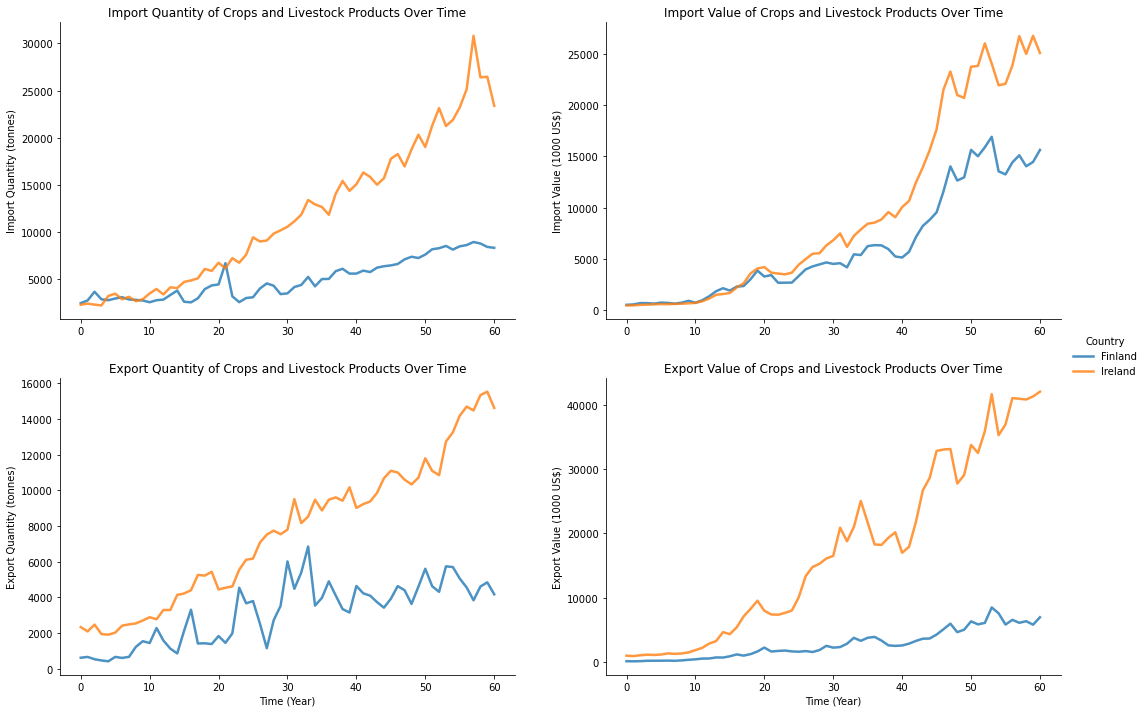

In [40]:
# concat the datasets to facilitate processing
imp_exp_avg_df = pd.concat([imp_data_avg, exp_data_avg])

# removing Slovakia data
imp_exp_avg_df = imp_exp_avg_df[imp_exp_avg_df['Area'] != 'Slovakia']

# getting the list of countries for the analysis
countries = list(imp_exp_avg_df['Area'].unique())

# getting the list of elements
elements = ['Import', 'Export']

# getting the list of measurements
measures = ['Quantity', 'Value']

# store each country import export timeseries in the list
imp_exp_ts_datasets = []

# collect dat for each country
for c in countries:
    # getting specific country dataset
    imp_exp_c_df = imp_exp_avg_df[imp_exp_avg_df['Area'] == c]
    
    # adjusting Slovakia's data to be comparable to other countries
    delta = 0
    if c == 'Slovakia':
        delta = 32

    # for each import/export dataset
    for el in elements:
        el_c_df = imp_exp_c_df[imp_exp_c_df['Element'].str.contains(el)]

        # apply scaler and add dummy time column to each dataset
        for ms in measures:
            ms_el_c_df = el_c_df[el_c_df['Element'].str.contains(ms)]
            
            # adding dummy index for the time series
            ms_el_c_df['Time_Index'] = np.arange(len(ms_el_c_df.index))

            # scaling the dataset - has to be done in the specific dataset
            ms_el_c_df_scaler = run_min_max_scaler(ms_el_c_df, ['Value'])
            ms_el_c_df.assign(Value=ms_el_c_df_scaler.Value)
            
            # adjusting delta as Slovakia's observations started from 1993
            ms_el_c_df['Time_Index'] = ms_el_c_df['Time_Index'] + delta

            # append timeseries to the list
            imp_exp_ts_datasets.append(ms_el_c_df)

# getting all timeseries per country per import/export val and quantity into the same dataframe
imp_exp_ts = pd.concat(imp_exp_ts_datasets)

# create the grid to display the import and export data
imp_exp_grid = sns.FacetGrid(imp_exp_ts, col='Element', hue='Area', 
                             height=5, aspect=1.5, sharey=False, sharex=False, col_wrap=2)

# map the above form facetgrid with some attributes
imp_exp_grid.map(sns.lineplot, 'Time_Index', 'Value', alpha=.8, linewidth=2.5)

# adding legend
imp_exp_grid.add_legend(title='Country')

# setting labels and titles
imp_exp_grid.set_xlabels('Time (Year)')
imp_exp_grid.set_titles('{col_name} of Crops and Livestock Products Over Time')

# adjusting space between graphs
imp_exp_grid.fig.subplots_adjust(wspace=.2, hspace=.2)

# iterate thorugh each axis
y_labels = ['Import Quantity (tonnes)', 'Import Value (1000 US$)', 'Export Quantity (tonnes)', 'Export Value (1000 US$)']
idx = 0
for ax in imp_exp_grid.axes.flat:
    ax.set_ylabel(y_labels[idx])
    ax.set_title(ax.get_title())
    idx+=1

#### Linear Regression

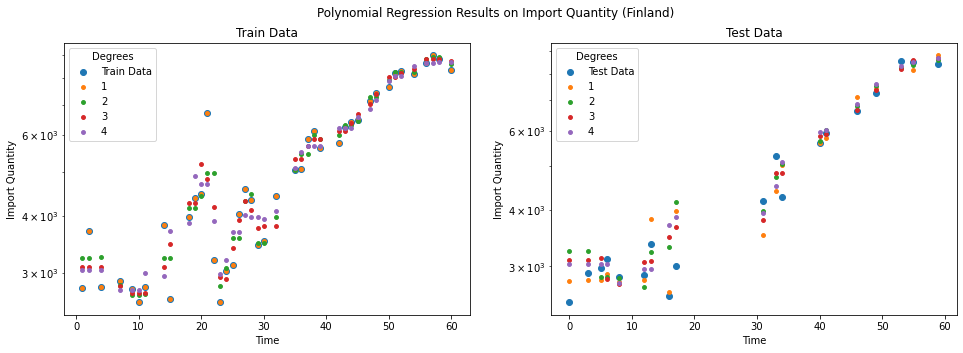

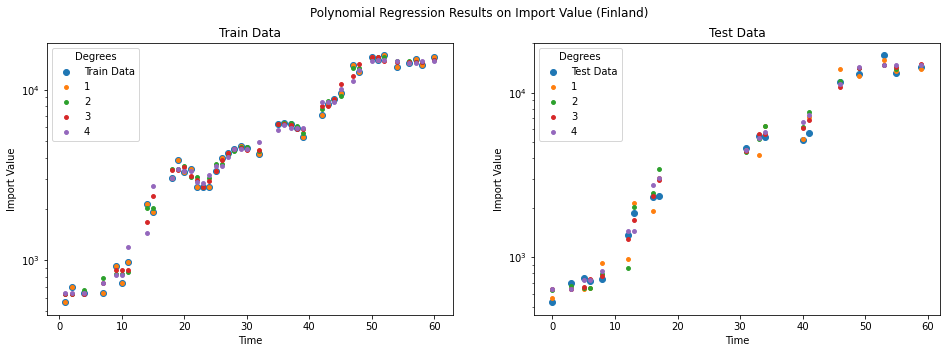

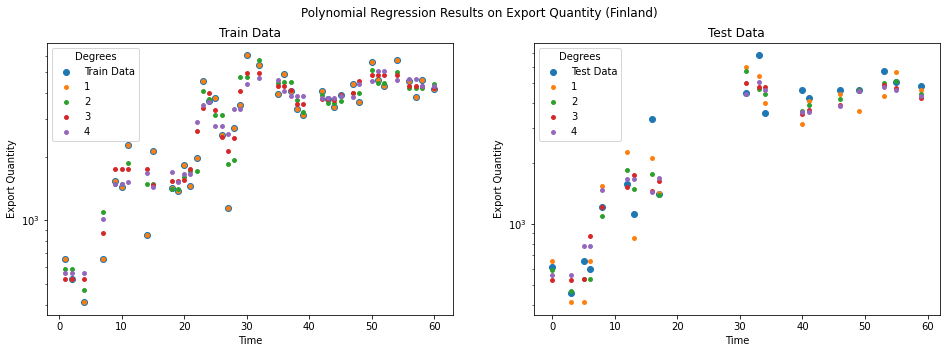

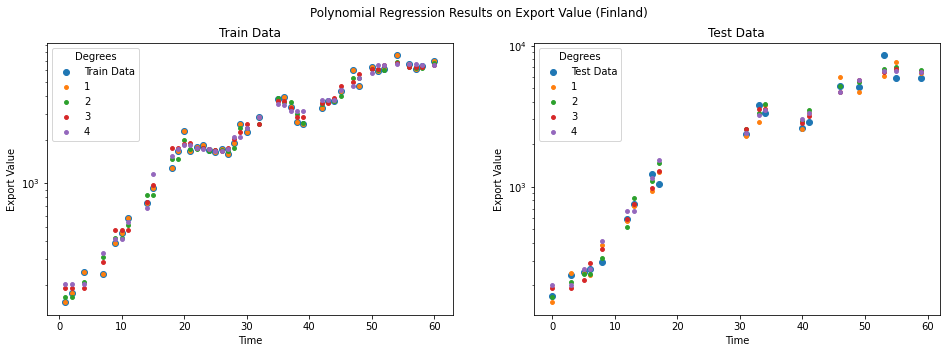

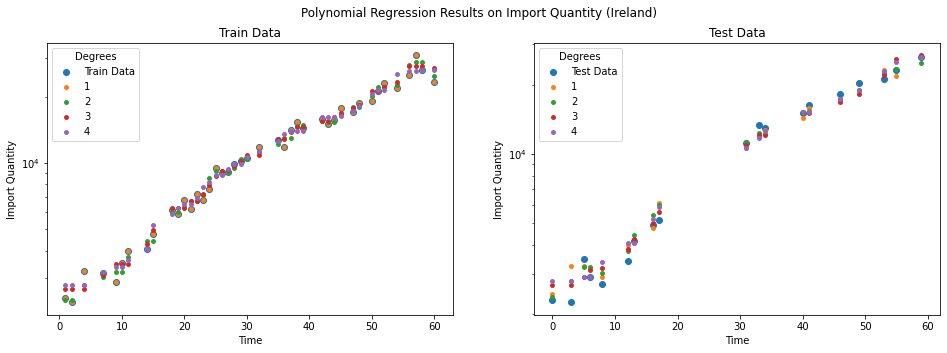

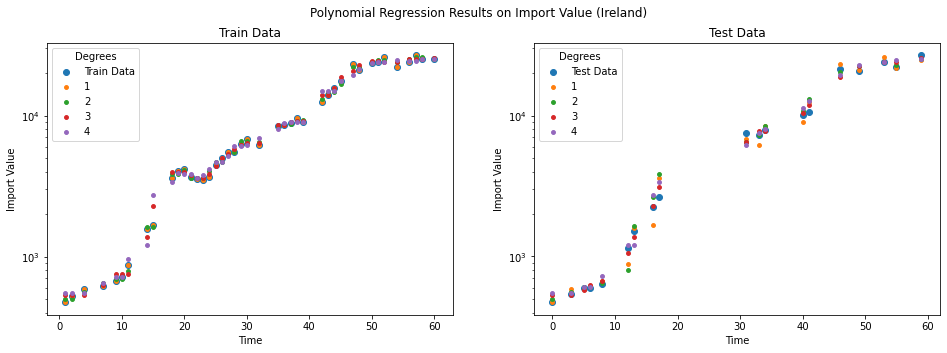

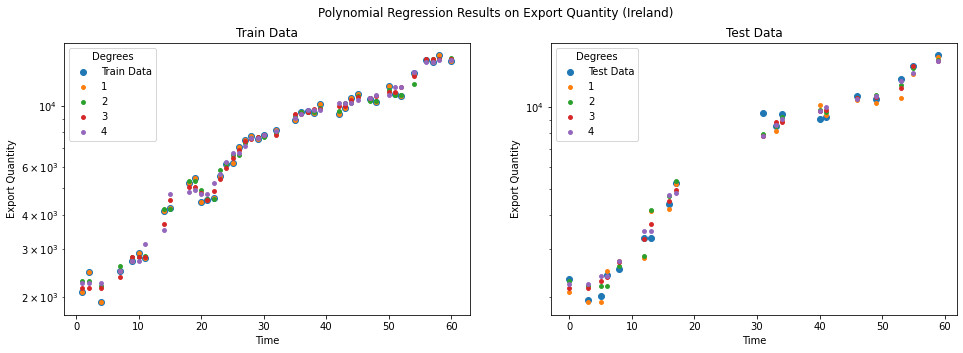

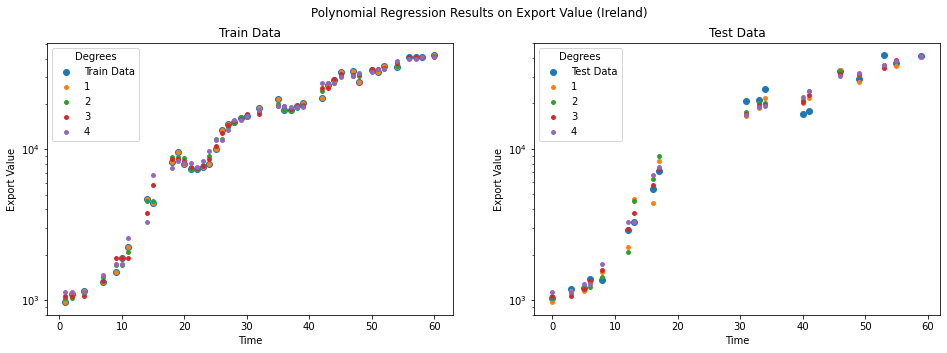

In [41]:
# polynomial degrees
#degrees = [1, 5, 10, 15, 20, 25, 30]
degrees = [1, 2, 3, 4]

# showing train and test data results
labels = ['Train Data', 'Test Data']

# store the results of the LR models
plr_results = []

# running model for all sub-datasets
for df_scaler in imp_exp_ts_datasets:
    # getting independent and target variables
    X, y = df_scaler['Time_Index'], df_scaler['Value']
    
    # getting dataset identification
    country = df_scaler['Area'].unique()[0]
    target = df_scaler['Element'].unique()[0]

    # running the poly regression model
    lr_results, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred = run_knn_regression_batch(X, y, target, degrees)
   
    # getting data to plot the results
    to_plot = [(X_train, y_train, y_train_pred), (X_test, y_test, y_test_pred)]
   
    # setting figure parameters
    plt.figure(figsize=(16, 5))
    subplot = 121
    
    # create graph for each train and test data
    for idx in range(0, len(to_plot)):
        # setting graph labels and parameters
        plt.subplot(subplot)
        plt.yscale('log')
        plt.suptitle(f'Polynomial Regression Results on {target} ({country})')
        plt.title(f'{labels[idx]}')
        plt.xlabel('Time')
        plt.ylabel(target)

        # getting data to plot (train or test)
        X_res, y_res, y_res_pred = to_plot[idx]
        
        # plotting original dataset
        plt.scatter(X_res, y_res, label=labels[idx])
        
        # plotting result of the regression
        for i, degree in enumerate(degrees): 
            plt.scatter(X_res, y_res_pred[:, i], s=15, label=f'{str(degree)}')
        
        # adding legend to the graph
        plt.legend(loc='best', title='Degrees')
        subplot+=1

    # keeping results
    plr_res_df = pd.DataFrame(lr_results, columns=['Element', 'Degree', 'Train_R2', 'Test_R2', 'CV_Train', 'CV_Test'])
    plr_res_df['Area'] = country
    plr_results.append(plr_res_df)

# getting dataframe with consolidated results
res_df = pd.concat(plr_results)

In [42]:
# showing results data
res_df

,Element,Degree,Train_R2,Test_R2,CV_Train,CV_Test,Area
0,Import Quantity,1,1.00,0.96,0.748109,0.919974,Finland
1,Import Quantity,2,0.95,0.95,0.854885,0.951896,Finland
2,Import Quantity,3,0.95,0.97,0.853704,0.944837,Finland
3,Import Quantity,4,0.94,0.95,0.813577,0.920801,Finland
0,Import Value,1,1.00,0.98,0.973994,0.936995,Finland
1,Import Value,2,0.99,0.97,0.967233,0.834546,Finland
2,Import Value,3,0.99,0.98,0.978078,0.890752,Finland
3,Import Value,4,0.98,0.97,0.958511,0.820785,Finland
0,Export Quantity,1,1.00,0.84,0.627262,0.435288,Finland
1,Export Quantity,2,0.91,0.85,0.688417,0.661639,Finland


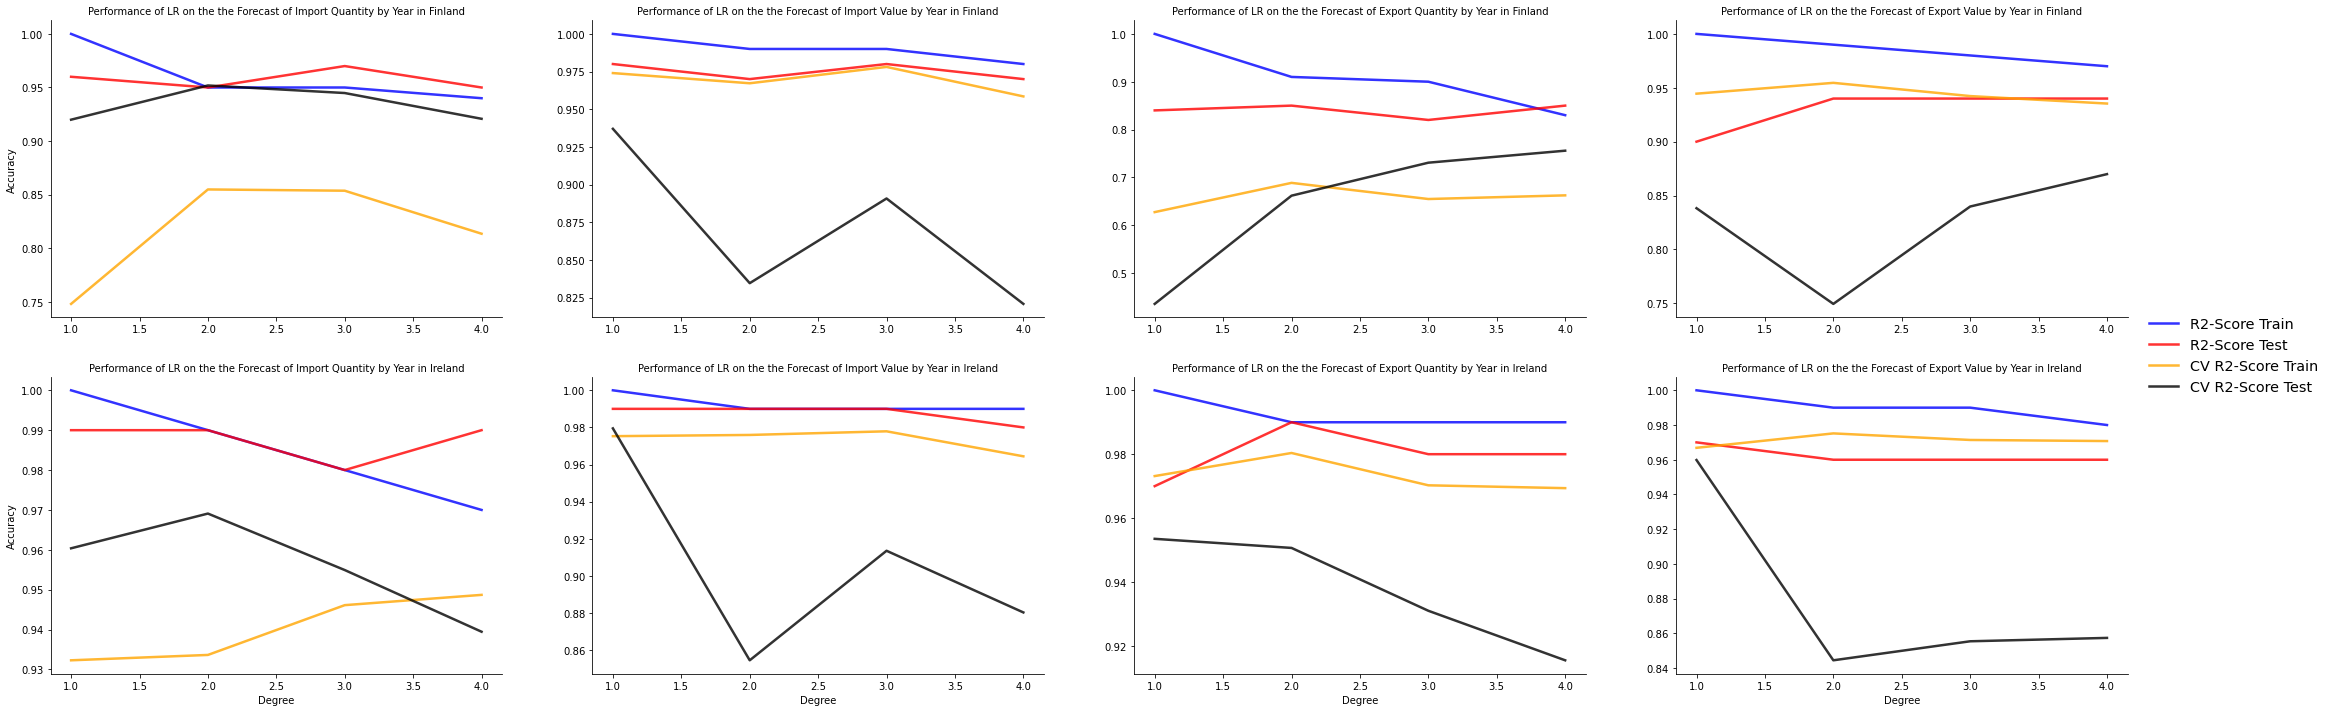

In [46]:
# create the grid to display the import and export data
perf_grid = sns.FacetGrid(res_df, row='Area', col='Element',
                          height=5, aspect=1.5, sharey=False, sharex=False)

# map the above form facetgrid with some attributes
perf_grid.map(sns.lineplot, 'Degree', 'Train_R2', alpha=.8, linewidth=2.5, color='blue', label='R2-Score Train')
perf_grid.map(sns.lineplot, 'Degree', 'Test_R2', alpha=.8, linewidth=2.5, color='red', label='R2-Score Test')
perf_grid.map(sns.lineplot, 'Degree', 'CV_Train', alpha=.8, linewidth=2.5, color='orange', label='CV R2-Score Train')
perf_grid.map(sns.lineplot, 'Degree', 'CV_Test', alpha=.8, linewidth=2.5, color='black', label='CV R2-Score Test')
perf_grid.add_legend(fontsize='x-large')

# adjusting space between graphs
perf_grid.fig.subplots_adjust(wspace=.2, hspace=.2)

# setting labels and titles
perf_grid.set_xlabels('Degree')
perf_grid.set_ylabels('Accuracy')

perf_grid.set_titles('Performance of LR on the the Forecast of {col_name} by Year in {row_name}')

#### KNN Regression

In [ ]:
knn_results_imp_exp_ire = []
max_k = 10
for v in to_model:
    # splitting data into train and test data for each vehicle
    X_train, y_train, X_test, y_test = get_train_test_data(df_scaler_ire, 'Time_Index', v)

    # prediction results for test and training datasets
    y_train_pred = np.zeros((len(X_train), max_k))
    y_test_pred = np.zeros((len(X_test), max_k))

    # trying knn regression with different k values
    for k in range(1, max_k):
        y_train_pred_k, y_test_pred_k = run_knn_regression(X_train, y_train, X_test, k)
        y_train_pred[:, k] = y_train_pred_k
        y_test_pred[:, k]  = y_test_pred_k
    
    # plotting train data
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.scatter(X_train, y_train)
    plt.yscale('log')
    plt.title(f'Train data for {v}')
    for k in range(0, max_k):    
        plt.scatter(X_train, y_train_pred[:, k], s=15, label=str(k))
        plt.legend(loc='upper left')

    # plotting test data
    plt.subplot(122)
    plt.scatter(X_test, y_test)
    plt.yscale('log')
    plt.title(f'Test data for {v}')
    for k in range(0, max_k):
        plt.scatter(X_test, y_test_pred[:, k], label=str(k))
        plt.legend(loc='upper left')

    # generate the validation results per degree with r2
    for k in range(1, max_k):
        train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, k]), 2)
        test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, k]), 2)
        knn_results_imp_exp_ire.append([v, k, train_r2, test_r2])

In [ ]:
# showing the scores for each K that was calculated for the train and test sets
knn_results_imp_exp_ire_df = pd.DataFrame(knn_results_imp_exp_ire, columns=['Import Value', 'Neighbors (K)', 'Train_R2', 'Test_R2'])
knn_results_imp_exp_ire_df

In [ ]:
# plotting a graph with the train and testing scores set from the results table
plt.plot(knn_results_imp_exp_ire_df['Neighbors (K)'], knn_results_imp_exp_ire_df['Train_R2'], label="training accuracy")
plt.plot(knn_results_imp_exp_ire_df['Neighbors (K)'], knn_results_imp_exp_ire_df['Test_R2'], label="testing accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbors (K)")
plt.legend()